# Segmentation

Vague definition:
> We want to classifify all image pixels to some distinct classes (often we want to distinguish foreground and background) and we will call this process or algorithms achieving this goal *segmentation*.

We will have two types:
1. Semantic segmentation - categories of objects
2. Instance segmentation - all instances of objects

## Example of  comparison of different operations with image

[image source](https://medium.com/analytics-vidhya/instance-segmentation-using-mask-r-cnn-on-a-custom-dataset-78631845de2a)

![al segmentation](./data/segmentation_all.jpeg)

## Example of semantic segmentation

[source of image](https://medium.com/cogitotech/what-is-the-difference-between-image-segmentation-and-classification-in-image-processing-303d1f660626)

![Semantic segmentation](./data/semantic_segmentation.jpeg)

## Example of instance segmentation

[image source](https://medium.com/@ylashin/quick-and-easy-guide-to-prepare-a-detectron-sandbox-940ccad8ffe2)

![Instance segmentation](./data/instance_segmentation.png)

In [1]:
# usual imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## Example 1 - Binary classification

In [2]:
img_path = os.path.join("data", "water_coins.jpg")
img = cv2.imread(img_path)
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #matplotlib still works in RGB
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

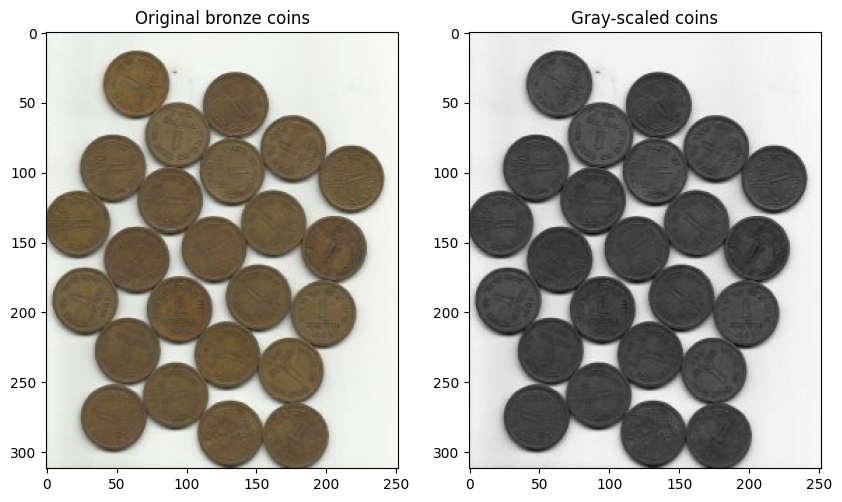

In [3]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(121)
ax1.set_title("Original bronze coins")
plt.imshow(img_color)

ax2 = plt.subplot(122)
ax2.set_title("Gray-scaled coins")
plt.imshow(img_gray, cmap="gray")

### Binary thresholding

In [4]:
THRESHOLDS = [10, 70, 150, 210, 240]
results = []
for t in THRESHOLDS:
    # read the docs if you are interested
    _, thresholded = cv2.threshold(img_gray, t, 255, cv2.THRESH_BINARY) # source, threshold, max value, type
    results.append(thresholded)

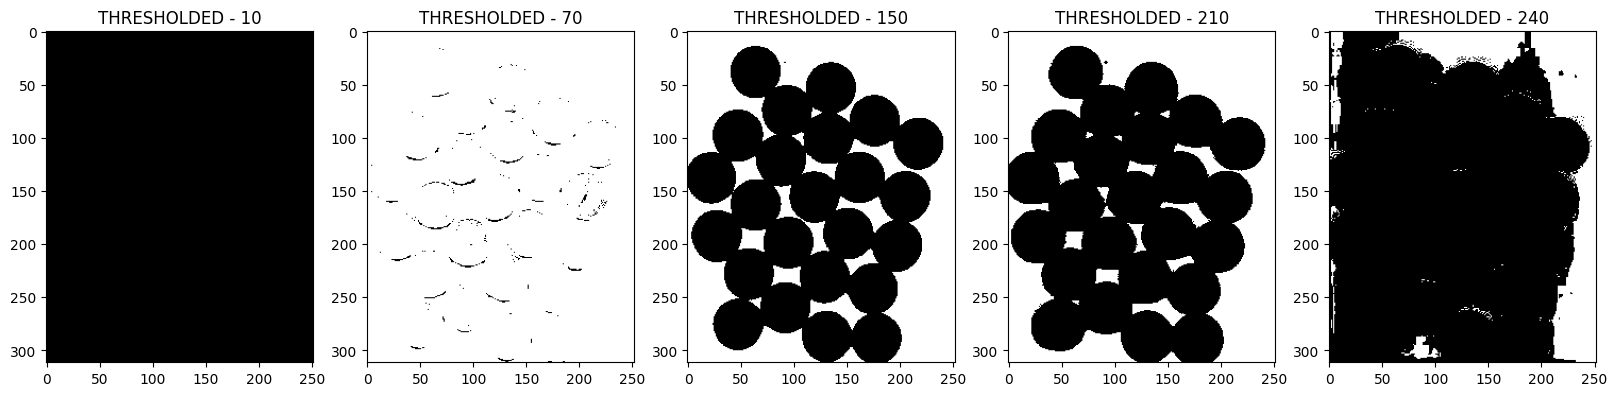

In [5]:
plt.figure(figsize=(20,8))

for i in range(len(THRESHOLDS)):
    ax = plt.subplot(1, len(THRESHOLDS), i+1)
    ax.set_title("THRESHOLDED - {}".format(THRESHOLDS[i]))
    plt.imshow(results[i], cmap="gray")

### OTSU and triangle thresholding

These algorithms will ignore *threshold* and tries to guess it somehow optimaly.

In [6]:
ret_otsu, thresholded_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_tri, thresholded_tri = cv2.threshold(img_gray, 155, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)

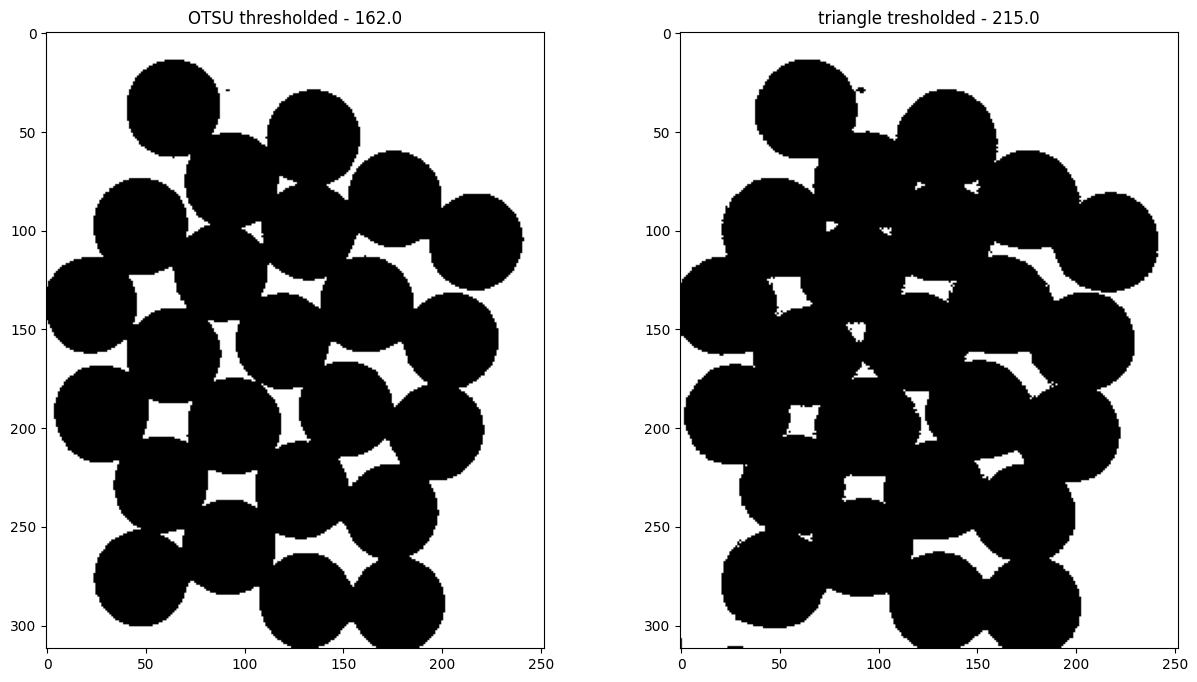

In [7]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
ax1.set_title("OTSU thresholded - {}".format(ret_otsu))
plt.imshow(thresholded_otsu, cmap="gray")

ax2 = plt.subplot(122)
ax2.set_title("triangle tresholded - {}".format(ret_tri))
plt.imshow(thresholded_tri, cmap="gray")

## Example 2 - Template matching (Where is the coin?)

In [8]:
coin_path = os.path.join("data", "coin_twosided.jpg")
coin = cv2.imread(coin_path)
coin_color = cv2.cvtColor(coin, cv2.COLOR_BGR2RGB) #matplotlib still works in RGB
coin_gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)

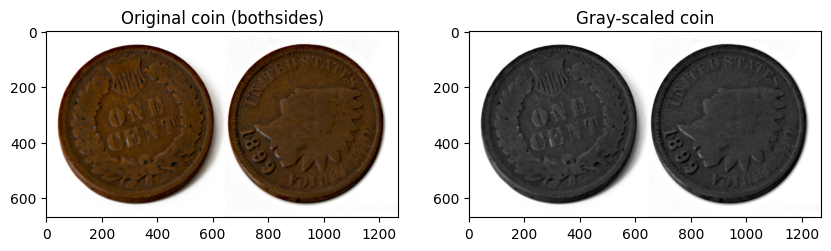

In [9]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.set_title("Original coin (bothsides)")
plt.imshow(coin_color)

ax2 = plt.subplot(122)
ax2.set_title("Gray-scaled coin")
plt.imshow(coin_gray, cmap="gray")

In [10]:
template_path = os.path.join("data", "coin_template.png")
template_color = cv2.imread(template_path)
template_gray = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)

In [11]:
COIN_SIZE = (560, 560) # coin size in pixels (guess from picture)
template = cv2.resize(template_gray, COIN_SIZE)
template_inverted = 255 - template
w, h = template.shape[::-1]

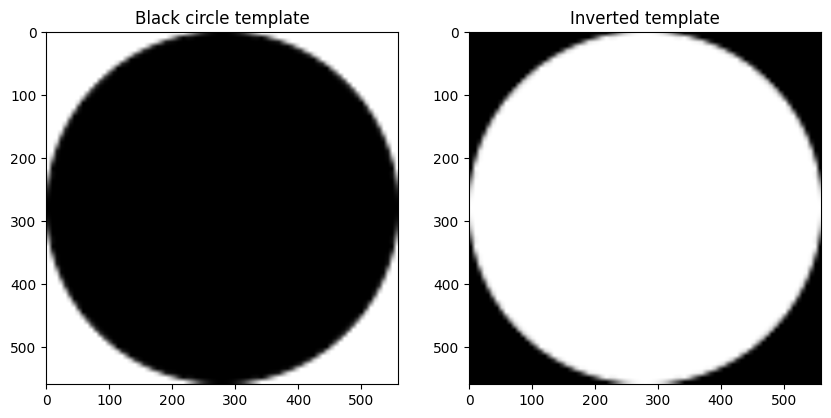

In [12]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.set_title("Black circle template")
plt.imshow(template, cmap="gray")

ax2 = plt.subplot(122)
ax2.set_title("Inverted template")
plt.imshow(template_inverted, cmap="gray")

### Naive approach - 2D correlate our template with grayscaled original

In [13]:
CORRCOEF_THRESHOLD_NAIVE = 0.88
coins_rgb_naive = np.copy(coin_color)
normed_corrcoef_naive = cv2.matchTemplate(coin_gray, template, cv2.TM_CCORR_NORMED)
loc_naive = np.where(normed_corrcoef_naive >= CORRCOEF_THRESHOLD_NAIVE)
for pt in zip(*loc_naive[::-1]):
    cv2.rectangle(coins_rgb_naive, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

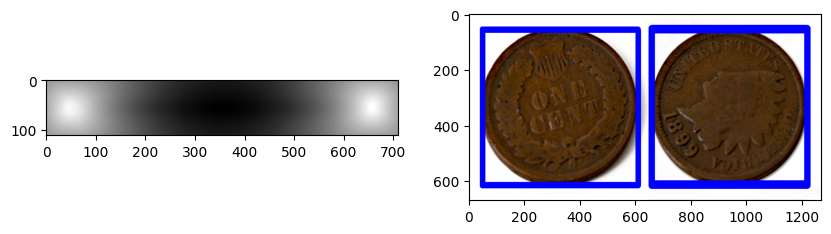

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(normed_corrcoef_naive, cmap="gray")

plt.subplot(122)
plt.imshow(coins_rgb_naive)

## Example 3 - Image and its background-foreground separation by histograms

In [15]:
zebra_path = os.path.join("data", "zebra.jpg")
zebra = cv2.imread(zebra_path)
zebra_color = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)
zebra_gray = cv2.cvtColor(zebra, cv2.COLOR_BGR2GRAY)

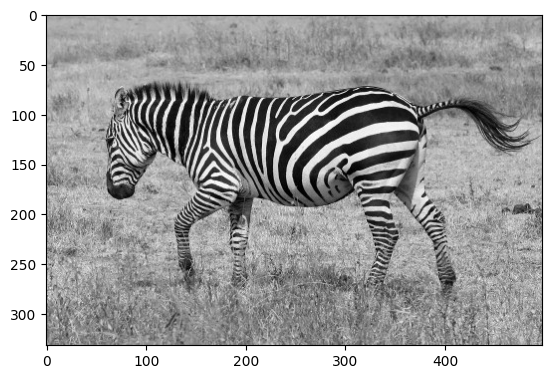

In [16]:
plt.imshow(zebra_gray, cmap="gray")

In [17]:
# USER PROVIDED INPUTS
BACKGROUND = [[(20,5),(250,40)], [(100,280),(250,320)]]
FOREGROUND = [[(100,95),(200,125)], [(295,110),(350,175)]]

In [18]:
# background histogram
background_regions = [zebra_gray[b[0][1]:b[1][1], b[0][0]:b[1][0]] for b in BACKGROUND]
background_joined = np.concatenate([x.flatten() for x in background_regions])
b_count, b_bins = np.histogram(background_joined, bins=256, range=(0.,256.), density=True)
b_x = b_bins[1:] - 0.5 
# foreground histogram
forground_regions = [zebra_gray[f[0][1]:f[1][1], f[0][0]:f[1][0]] for f in FOREGROUND]
foreground_joined = np.concatenate([x.flatten() for x in forground_regions])
f_count, f_bins = np.histogram(foreground_joined, bins=256, range=(0.,256.), density=True)
f_x = f_bins[1:] - 0.5

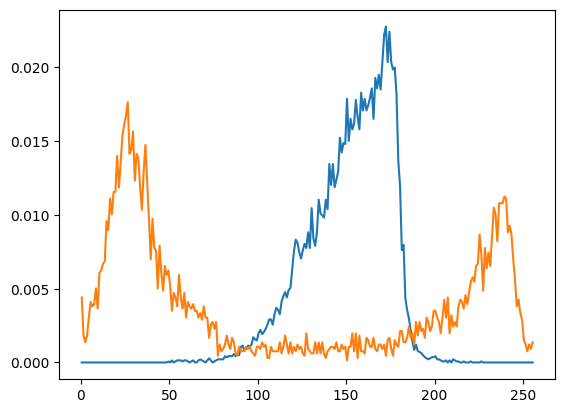

In [19]:
plt.plot(b_x, b_count)
plt.plot(f_x, f_count)

In [20]:
mask = f_count > b_count
start_value = np.argmin(f_count > b_count)
end_value = 255 - np.argmin(np.flip(f_count) > np.flip(b_count))

In [21]:
foreground_mask = (zebra_gray >= start_value)&(zebra_gray <= end_value)

In [22]:
regions = np.copy(zebra_color)
regions[:,:,0] = ~(foreground_mask) * 255
regions[:,:,1] = 0
regions[:,:,2] = foreground_mask * 255

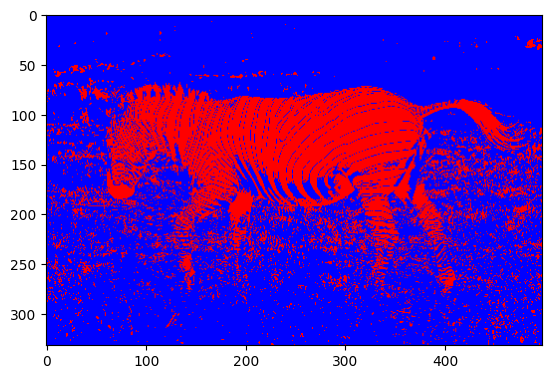

In [23]:
plt.imshow(regions)

In [24]:
zebra_regions = np.copy(zebra)
for b in BACKGROUND:
    cv2.rectangle(zebra_regions, b[0], b[1], (0,0,255), 2)
for f in FOREGROUND:
    cv2.rectangle(zebra_regions, f[0], f[1], (255,0,0), 2)

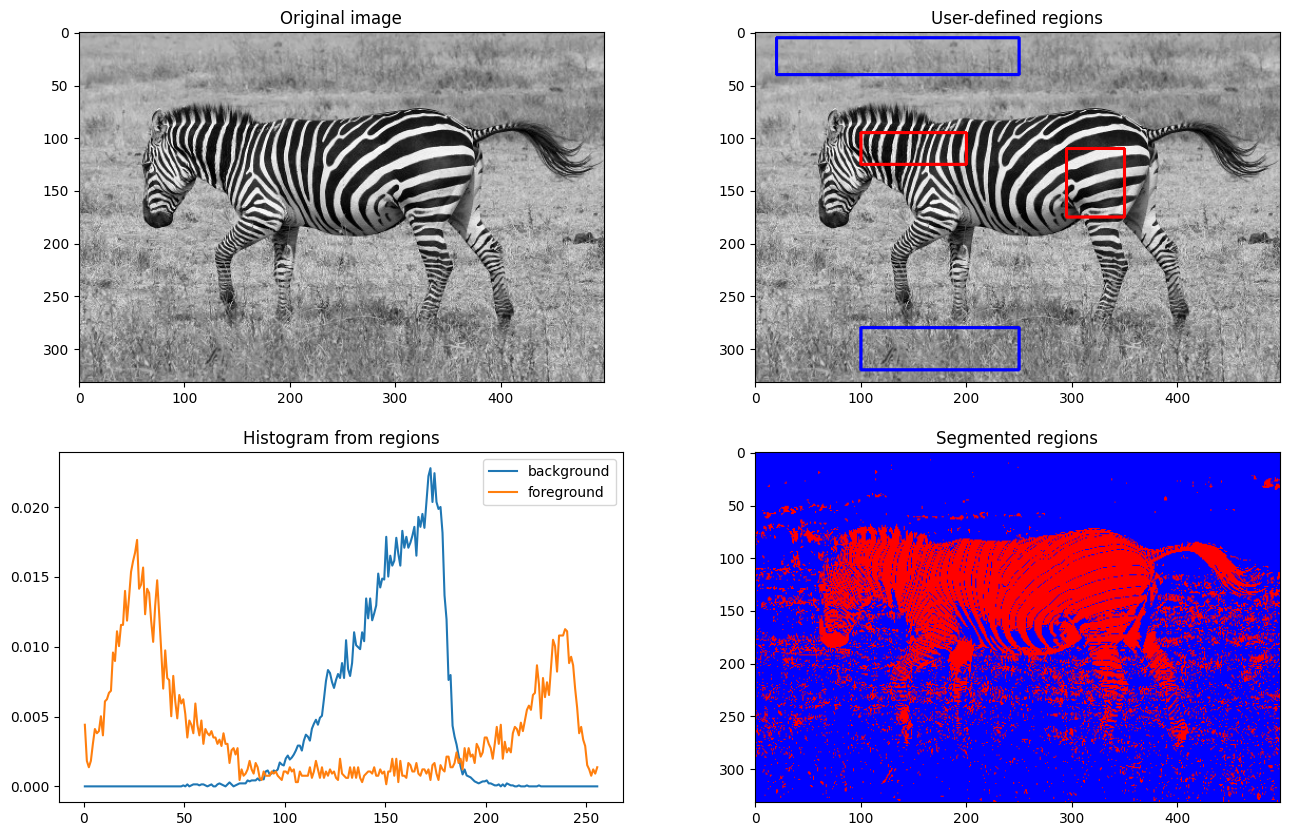

In [25]:
plt.figure(figsize=(16,10))

ax1 = plt.subplot(221)
ax1.set_title("Original image")
plt.imshow(zebra)

ax2 = plt.subplot(222)
ax2.set_title("User-defined regions")
plt.imshow(zebra_regions)

ax3 = plt.subplot(223)
ax3.set_title("Histogram from regions")
plt.plot(b_x, b_count, label="background")
plt.plot(f_x, f_count, label="foreground")
plt.legend()

ax2 = plt.subplot(224)
ax2.set_title("Segmented regions")
plt.imshow(regions)